# Plot polar maps of boreal domain data - Cicrumpolar Site Index
Paul Montesano, PhD   
Oct 2024  
* ran this notebook R kernel on workspace `r_v3.1.5`

In [1]:
#system("conda activate r-with-gdal")

In [254]:
library(aws.s3)
#library(rgdal)
library(raster)
library(tidyverse)
library(dplyr)
library(grid)
library(gridExtra)
library(RColorBrewer)
library(data.table)

library(fs)
library(sf)
#library(rgdal)

library(rgeos)
library(mapproj)
#library(rgee)
library(viridis)
#library(wesanderson)
library(scales)
library(tools)
library(patchwork)

library(rnaturalearth)
library(rnaturalearthdata)
#library(feather)

#conda install -c conda-forge r-rnaturalearth r-rnaturalearthdata r-mapproj r-rgeos r-viridis r-wesanderson r-patchwork r-aws.s3 r-feather r-rockchalk

# Paths to raster for mapping

In [255]:
r_fn_list = c(
    '/projects/my-public-bucket/tmp/SI35_1.tif',
        '/projects/my-public-bucket/tmp/SI35_1.tif'

    )

r_names_list = c(
        'SI35', 'SI35_test'
    )

In [256]:
boreal_shp_fn = '/projects/shared-buckets/montesano/databank/arc/wwf_circumboreal_Dissolve.gpkg'
#boreal_shp_fn = '/projects/shared-buckets/montesano/databank/arc/boreal.shp'

## Set output figure dir.

In [257]:
OUT_FIGURE_DIR = '/projects/my-public-bucket/boreal_polar_map/site_index_boreal'

### Mapping functions and vars

In [258]:
source('/projects/code/3dsi/boreal_map_functions.R') 

[1] "MAAP"
[1] "MAAP"


#### Note: the ability to make these maps is changing...

The use of type 'SpatialPolygons' will go away.  
This means 'crop' will need to be changed to crop an 'sf' object.

But the whole polar mapping function is built around the use of 'SP', not 'sf'.-  

THis will need work and testing to be able to reproduce these polar maps.

At the moment, these still works in `r-env-3.6.3` on Prism

In [259]:
# Circ map new: trying to combine the best of the sf and sp approaches
DO_MAP_BOREAL_SP <- function( MAP_EXTENT = extent(-180,180,45,90), xlim=NULL, ylim=NULL, rotate_map=0, proj_name = 'azequalarea', LAYER_LIST=NULL, 
                             BOREAL_SHP_FN = '/projects/my-public-bucket/misc_files/Ecoregions2017_boreal_m.shp'){
  #
  # Map with a polar projection
  #
  
  # Color scale help
  #https://biostats.w.uib.no/color-scale-for-continuous-variables/
  
  #source(path("C:\\Users\\pmontesa\\Google Drive\\Work\\R","plot_functions.R"))
  # Shapefiles
  
  
  #world <- crop(ne_countries(scale = "medium", returnclass = "sp"), MAP_EXTENT)
  world <- raster::crop(as(ne_countries(scale = "medium", returnclass = "sf"), 'Spatial'), MAP_EXTENT)
  #world = st_crop(x = ne_countries(scale = "medium", returnclass = "sf") %>% st_make_valid() ,  y = ext)
  
  # WWF
  #boreal <- shp_fort_join("D:\\databank\\wwf\\arc\\wwf_circumboreal_Dissolve.shp", MAP_EXTENT, REPROJECT = TRUE)
  # TerraPulse
  boreal <- shp_fort_join(boreal_shp_fn, MAP_EXTENT, REPROJECT = TRUE)
  
  map_list_base = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill="grey90", color=NA),
    geom_polygon(data = boreal, aes(x = long, y = lat, group = group), color=NA, fill="grey70"))
    
  map_list_top = list(
    
    geom_polygon(data = fortify(world), aes(x = long, y = lat, group = group), fill=NA, color="black", size=0.1 ),
    
    theme_minimal() , 
    theme(axis.text = element_blank(), axis.title = element_blank() ) ,
    
    #geom_polygon(data = fortify(continents.df_stereo), aes(x = long, y = lat, group = group), fill = NULL, colour = "black", size=0.25) +
    #scale_color_distiller(palette = "Greens", direction = 1, name = "%"),
    #scale_color_manual(values = COLOR_PAL, name = map_str) ,
    guides(guide = guide_legend(direction = "horizontal", nrow=1, label.position = "bottom", title.position = "bottom") ) ,
    theme(legend.position="top",
          legend.title = element_text(size=9),
          #       legend.direction  = 'vertical',
          legend.key.width  = unit(1.0, "cm"),
          legend.key.height = unit(.25, "cm")  )
  )
  
  if(is.null(LAYER_LIST)){
    map_list = list(
      map_list_base,
      map_list_top
    )
  }else{
    map_list = list(
      map_list_base,
      LAYER_LIST,
      map_list_top
    )
  }
  
  p_map = ggplot() + map_list +
    #coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map, xlim = xlim, ylim = ylim)
    coord_map_stereo_list(proj_name = proj_name, min_lat = MAP_EXTENT[3], rotation=rotate_map)
  
  if(FALSE){
    out_plot_fn = paste0("D:/projects/3dsi/plots/map_boreal_",proj_name,"_", format(Sys.time(), "_%Y%m%d"),'.png')
    print(out_plot_fn)
    ggsave(plot = p_map ,
           file = out_plot_fn,
           device = 'png', dpi = 300, width = 5, height = 5)
  }
  #print(p_map)
  return(p_map)
  
}

coord_map_stereo_list <- function(proj_name = "stereo", rotation = 0, min_lat = 50, xlims=NULL, ylims=NULL, LABEL_SIZE=3){ 
  
  # Defines the x axes required
  lat_lines = seq(min_lat+10, 80, by = 10)
  lat_labs = paste0(seq(min_lat+10, 80, by = 10), "\u00B0N")
  
  lon_lines = seq(0, 330, by = 30)
  lon_labs = c("0", paste0(seq(30, 150, by = 30), "°E"), "180", rev(paste0(seq(30, 150, by = 30), "°W")))
  
  
  return(list(
    # Convert to polar coordinates
    coord_map(proj_name, orientation = c(90, 0, rotation, xlims=xlims, ylims=ylims)), #"ortho""
    scale_y_continuous(breaks = seq(45, 90, by = 5), labels = NULL),
    
    # Removes Axes and labels
    scale_x_continuous(breaks = NULL),
    xlab(""),
    ylab(""),
    
    # Adds axes
    # Latitude
    geom_hline(aes(yintercept = lat_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    # Outer circular border
    geom_hline(aes(yintercept = min_lat), size = 0.25), #1
    # Longitude
    geom_vline(aes(xintercept = lon_lines), size = 0.25, color = "grey80", linetype = "dotted"),
    #geom_segment(aes(y = 45, yend = 85, x = x_lines, xend = x_lines), linetype = "dotted") +
    
    # Adds labels
    #geom_text(aes(x = 0, y = lat_lines, hjust = 0.5, label = lat_labs)),
    geom_label(aes(x = 0, y = lat_lines, label = lat_labs), label.size = NA, size=LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),
    #geom_text(aes(x = lon_lines, y = min_lat-3, hjust = 0.5, vjust = 0.5, label = lon_labs), size = 2.5), #hjust = 0.5
    # min-3 so lon labels are centered over outer line
    geom_label(aes(x = lon_lines, y = min_lat-3, label = lon_labs), label.size = NA,  hjust='inward', vjust='inward', size = LABEL_SIZE, color = "black", fill="white", label.padding=unit(0.1,"lines")),  #y = min_lat-3 why used to be this?
    
    ##guides(fill=FALSE)+
    
    # Change theme to remove axes and ticks
    theme(panel.background = element_blank(),
          #panel.grid = element_line(size = 0.25, linetype = 'dotted', colour = "grey50"),
          axis.ticks=element_blank())
    #,
    #labs(caption = "Source: circ_tte_map.Rmd")
  ))
}  

gridCreate<-function(shp, res,proj_out, buffer=10000){
  
  if (!is.null(buffer)){
    shp<-buffer(shp, width=buffer)
  }
  ext <- floor(extent(shp))
  rr <- raster(ext, res=res)
  rr <- rasterize(shp, rr, field=1)
  rr[!is.na(rr[])]<-1:length(rr[!is.na(rr[])])
  grid<-rasterToPolygons(rr)
  crs(grid)<-projection(shp)
  if (!proj_out==projection(shp)){
    grid<-spTransform(grid,CRS(proj_out))
  }
  return(grid)  
}

In [260]:
crs_canalb = "+proj=aea +lat_0=40 +lon_0=180 +lat_1=50 +lat_2=70 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs"
crs_albers = "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=180 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs"
crs_gcs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

### Get Boreal EXTENT

#### Read boreal extent, read tiles, then clip tiles to boreal extent

In [261]:
boreal_shp_fn = '/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson'
boreal = st_read(boreal_shp_fn)
boreal_albers<-spTransform(sf:::as_Spatial(boreal),CRS(crs_albers))

Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


In [262]:
ext = extent(-180,180,40,90)

### Map Site Index
##### Using a raster that gets reprojected to lat/lon

#### Convert raster to points, sample

In [263]:
for(i in seq_along(r_fn_list)){
    r_fn = r_fn_list[i]
    r = raster(r_fn, band=1)
    names(r) = r_names_list[i]
    
    # Convert to df 
    r_p <- sample_frac(data.frame(rasterToPoints(r)), 1) #0.01 sample is good for draft work
    
    names(r_p) = c('x','y','value')
    r_p$variable = names(r)
    
    df_list[[names(r)]] = r_p
    rm(r_p)
}
r_p = do.call('rbind', df_list)
dim(r_p)

[1] 26526     4

#### Convert dataframe to `sf` in lat/lon coords

In [264]:
r_sf = st_as_sf(r_p, coords = c('x','y') , crs = crs_gcs)

#### Convert points `sf` to vector grid summary with the `mean` value

In [265]:
# Get the bounding box (extent) of the points data
bbox <- st_bbox(r)

# Define the grid resolution (e.g., 1x1 degrees for this example)
grid_size <- 0.5

# Create a grid over the extent of the points
grid <- st_make_grid(r_sf, cellsize = grid_size, what = "polygons", offset = round(st_bbox(bbox)[c("xmin", "ymin")] - 0.5, 0) ) # round down and snap to lower left integer lon, lat

# Convert the grid to an sf object
grid_sf <- st_sf(geometry = grid)

# Perform a spatial join between the grid and the points
# This will join the points' values to the grid cells
grid_with_points <- st_join(grid_sf, r_sf, join = st_contains) 

# If there are multiple points in the same grid cell, you may want to summarize the results
# e.g., summarize by taking the mean value of points in each grid cell
grid_summary <- grid_with_points %>%
  group_by(geometry, variable) %>%
  summarize(mean_value = mean(value, na.rm = TRUE)) %>% drop_na()

`summarise()` has grouped output by 'geometry'. You can override using the
`.groups` argument.


#### Save the vectorized raster

In [ ]:
grid_summary %>% st_write(dsn = '/projects/my-public-bucket/tmp/grid_summary_SI35.gpkg', layer ='grid_summary_SI35') 

### Fortify to link attributes to summary grid

In [267]:
grid_summary_sp = as_Spatial(grid_summary)

#Get attributes, fortify data, and merge attributes to data
tbl = grid_summary_sp@data
tbl$id <- rownames(tbl)
grid_summary.df <- ggplot2::fortify(grid_summary_sp, id = "id")
grid_summary_df = plyr::join(grid_summary.df, tbl, by = "id")

Regions defined for each Polygons


In [268]:
if(FALSE){
     grid_summary_df$zone_name = ifelse(grid_summary_df$long == -90.5, 'a', 
                                    ifelse(grid_summary_df$long == -91, 'b', ifelse(grid_summary_df$long == 28, 'c', 'other')
                                           )
                                   )
    }

grid_summary_df$REALM = factor(ifelse(grid_summary_df$long < -30, "North America", "Eurasia"), levels=c("North America", "Eurasia"))

In [269]:
if(FALSE){
    # Get the name and the y position of each label
    label_data <- grid_summary_gdf %>% filter(zone_name != 'other') %>% dplyr::group_by(long, zone_name) %>% dplyr::summarize(mean_lon_zone=round(mean(mean_value),2)) 
    number_of_bar <- 360/grid_size 
    angle <- label_data$long-0.5 + 90     

    label_data$hjust <- ifelse( angle < -90, 1, 0)
    label_data$hjust <- ifelse( angle < -90, 0, 1)
    label_data$angle <- ifelse(angle < -90, angle+180, angle)

    label_data$lat = 85

    label_data  = label_data %>% drop_na()
    label_data
    }

### Build a points dataframe of the raster

#### Convert `sf` to a `spatial` dataframe

In [270]:
if(FALSE){
    r_geo_p =  as_Spatial( r_sf
                        #st_intersection(r_sf, 
                                        #st_as_sf(boreal_albers) %>% select(REALM)%>% st_transform(crs = crs_gcs)
                                      # ) 
                        )%>% 
                as.data.frame()
    # names(r_geo_p)[1] = "value"
    names(r_geo_p)[length(names(r_geo_p))-1] = "x"
    names(r_geo_p)[length(names(r_geo_p))] = "y"
    class(r_geo_p)
    tail(r_geo_p)
    }

In [271]:
head(grid_summary_df)

,long,lat,order,hole,piece,id,group,variable,mean_value,REALM
,<dbl>,<dbl>,<int>,<lgl>,<fct>,<chr>,<fct>,<chr>,<dbl>,<fct>
1,-91.0,44.5,1,FALSE,1,1,1.1,SI35,14.1246,North America
2,-91.0,45.0,2,FALSE,1,1,1.1,SI35,14.1246,North America
3,-90.5,45.0,3,FALSE,1,1,1.1,SI35,14.1246,North America
4,-90.5,44.5,4,FALSE,1,1,1.1,SI35,14.1246,North America
5,-91.0,44.5,5,FALSE,1,1,1.1,SI35,14.1246,North America
6,-91.0,44.5,1,FALSE,1,2,2.1,SI35.test,14.1246,North America


## Map

In [283]:
map_extent = extent(-180, 180, 45, 90)
min_lat = map_extent[3]
MAX_SI = 30

pal_ht = c('black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850')
LIST_SCALE_FILL = c(
                scale_fill_gradientn( breaks=c(0,5,10,15, 20, 25, MAX_SI), limits = c(0, MAX_SI), colors=pal_ht),
                scale_fill_viridis( breaks=c(0,5,10,15, 20, 25, MAX_SI), limits = c(0, MAX_SI), option = 'turbo'),
                scale_fill_viridis( breaks=c(0,5,10,15, 20, 25, MAX_SI), limits = c(0, MAX_SI), option = 'rocket')
    )

In [284]:
levels(factor(grid_summary_df$variable))

[1] "SI35"      "SI35_test" "SI35.test"

In [288]:
options(repr.plot.width =8, repr.plot.height =8, repr.plot.res = 300)

map_list = list()

theme_and_labs = list(
        theme_classic()
        #, labs(
        #     title = expression("Circumpolar boreal forest stand height ["~90^{th}~"percentile]")
        # )
    )

for(i in seq_along(levels(factor(grid_summary_df$variable))) ){
    
    VAR = levels(factor(grid_summary_df$variable))[i]
    scale_fill_SI = LIST_SCALE_FILL[i]
    
    SI35_layer_list = list( 
        geom_polygon(data = grid_summary_df %>% drop_na() %>% filter(variable == VAR)
                     , aes(x = long, y = lat, group = group, fill=mean_value), color='black', size=0.01)
        , scale_fill_SI
        , guides(fill=guide_colourbar(title=expression("Stand height (m) of "~SI[35]~""), 
                                     title.position = "top", label.position = "bottom", keywidth = unit(.5, "cm"), keyheight = unit(.25, "cm")))
        , theme_and_labs
        )

    map_list[[VAR]] = DO_MAP_BOREAL_SP(MAP_EXTENT=map_extent, BOREAL_SHP_FN = wwf_circ_dis_fn, LAYER_LIST = SI35_layer_list)

}


# m_AGB_mean_std = (m_AGB_mean / m_AGB_std) +
#           plot_annotation(tag_levels = "a")                   
                             
#out_dir = dirname(r_fn)
#DATA_NAME_STEM = "AGB_boreal"
DATA_NAME_STEM = tools::file_path_sans_ext(basename(r_fn))
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")


[1] "Using sf and coercing to Spatial object..."
Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


[1] "Using sf and coercing to Spatial object..."
Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


[1] "Using sf and coercing to Spatial object..."
Reading layer `wwf_circumboreal_Dissolve' from data source 
  `/projects/shared-buckets/nathanmthomas/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson' 
  using driver `GeoJSON'
Simple feature collection with 2 features and 4 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -164.95 ymin: 44.39544 xmax: 169.9216 ymax: 71.41746
Geodetic CRS:  WGS 84


Regions defined for each Polygons
Regions defined for each Polygons
Regions defined for each Polygons


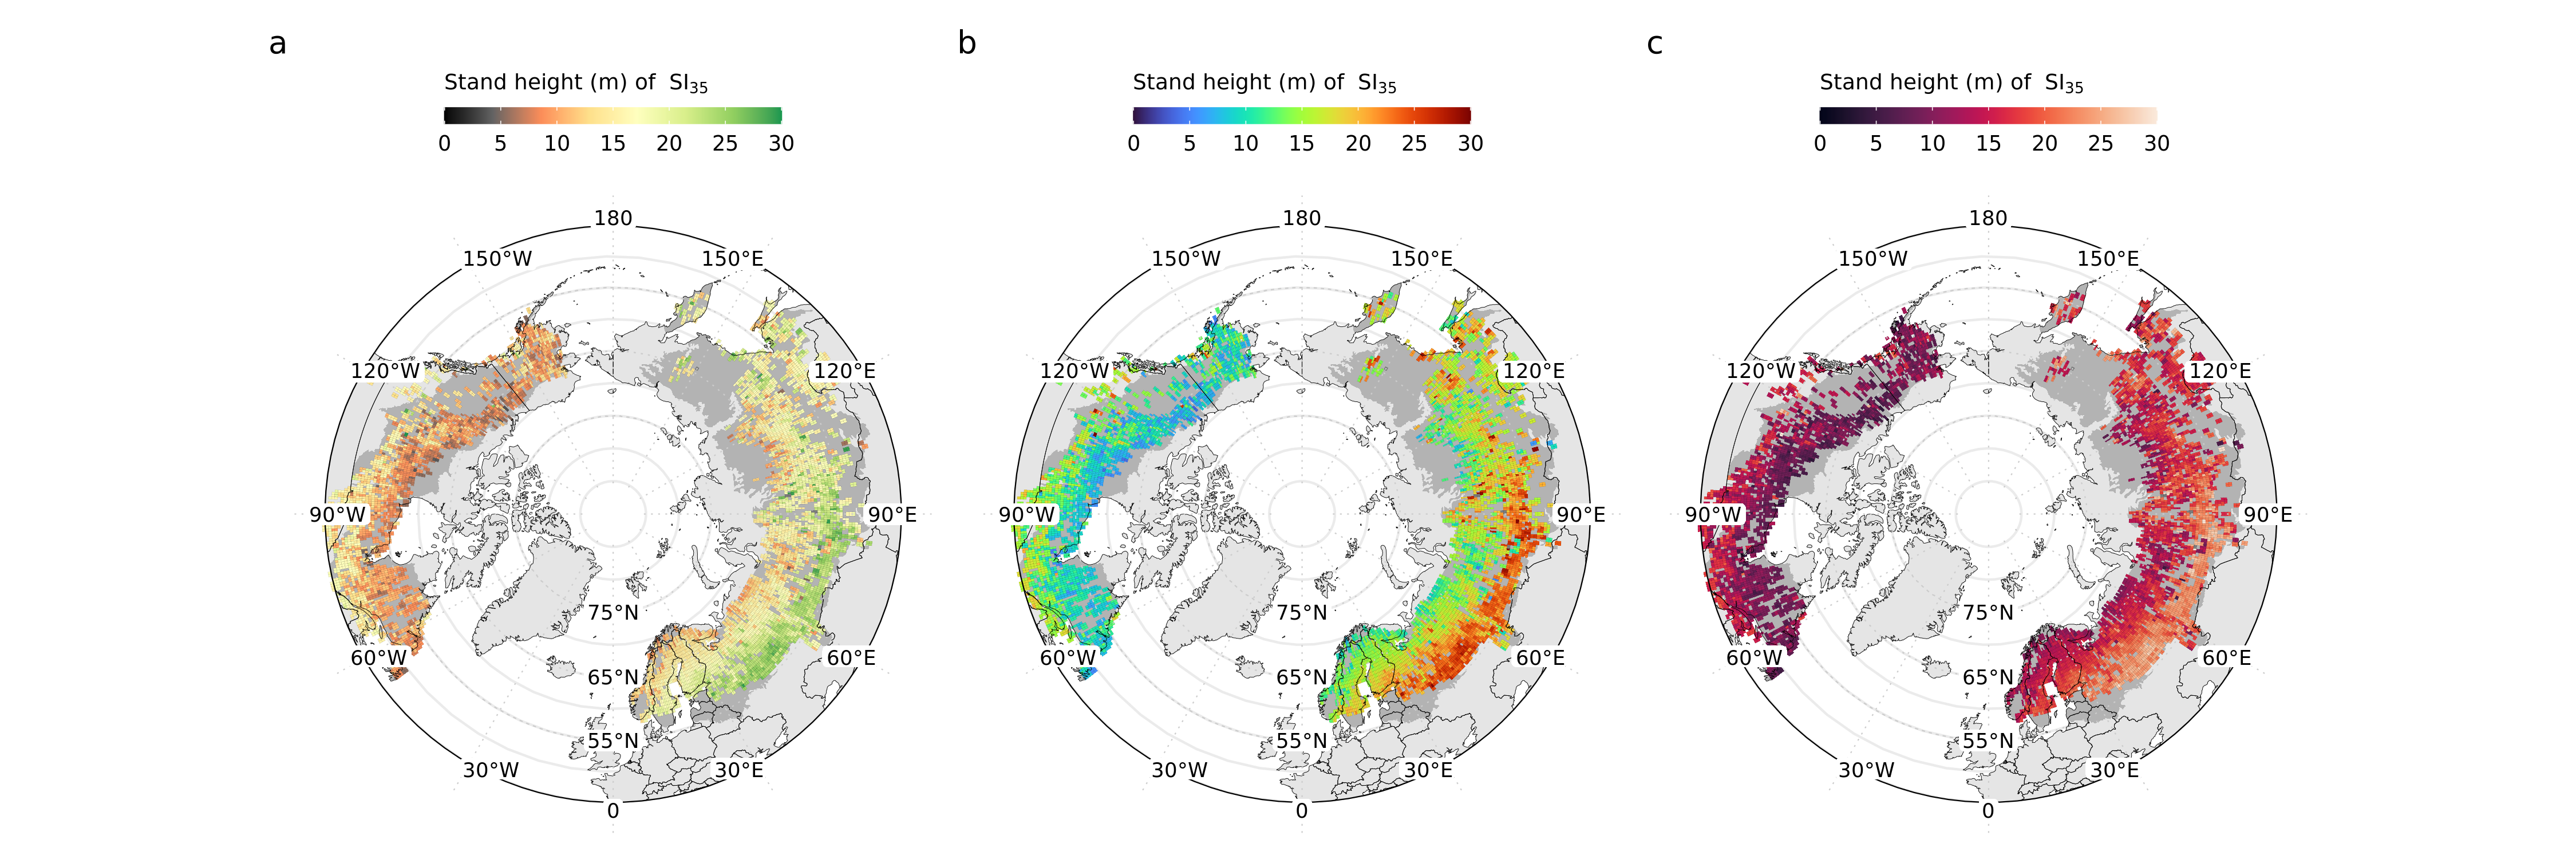

In [293]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 300)

fig_2 = (map_list[['SI35']] | map_list[['SI35_test']] | map_list[['SI35.test']]) +
          plot_annotation(tag_levels = "a")  

fig_2

## Export figure

In [294]:
DATA_NAME_STEM = "fig_2_boreal_site_index_TEST"
EXPORT_TIME_STR = format(Sys.time(), "_%Y%m%d")

for(OUT_TYPE in c('png', 'pdf')){
    map_fn = path('/projects/my-public-bucket/boreal_site_index', paste0("map_",DATA_NAME_STEM, EXPORT_TIME_STR,".", OUT_TYPE))
    print(map_fn)
    ggsave(plot = fig_2,
           file = map_fn,
           device = OUT_TYPE, dpi = 300, width = 15, height = 5)
}

/projects/my-public-bucket/boreal_site_index/map_fig_2_boreal_site_index_TEST_20241007.png
/projects/my-public-bucket/boreal_site_index/map_fig_2_boreal_site_index_TEST_20241007.pdf


In [282]:
# ggplot() +
#     geom_polygon(data = grid_summary_df %>% drop_na()
#                  , aes(x = long, y = lat, group = group, fill=mean_value), color='black', size=0.01) + 
#     facet_wrap(variable ~ . , ncol=2)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


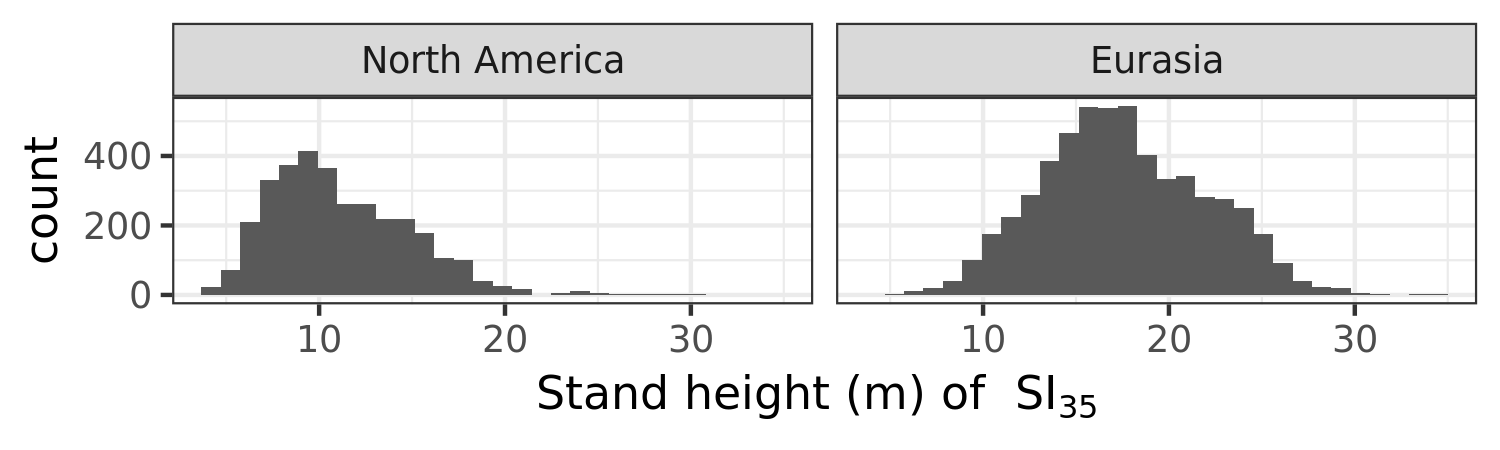

In [177]:
options(repr.plot.width =5, repr.plot.height =1.5, repr.plot.res = 300)

r_geo_p$REALM = factor(ifelse(r_geo_p$x < -30, "North America", "Eurasia"), levels=c("North America", "Eurasia"))

ggplot(r_geo_p, aes(x=value)) + 
geom_histogram() +
theme_bw() +
facet_wrap(REALM ~.) +
labs(x=expression("Stand height (m) of "~SI[35]~""))